In [1]:
# import the libraries you need, make sure they are installed within your Python env
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import missingno as msno
from scipy.stats import skew, norm
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


pd.options.display.width = None
print("Libraries imported successfully")

Libraries imported successfully


### Read the Jointed File

In [2]:
orig_dt = pd.read_csv("jointed_EA.csv")

### Replace None as nan

In [3]:
import concurrent.futures
def replace_none_with_nan(df):
    df.replace("None", np.nan, inplace=True)
    return df

# Split the dataframe into smaller chunks
chunks = np.array_split(orig_dt, 4)

# Use a ThreadPoolExecutor to execute the code in multiple threads
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(replace_none_with_nan, chunk) for chunk in chunks]
    
    # Wait for all threads to finish
    concurrent.futures.wait(results)
    
    # Combine the results into a single dataframe
    orig_dt = pd.concat([result.result() for result in results])

DoneAndNotDoneFutures(done={<Future at 0x7fb1699798b0 state=finished returned DataFrame>, <Future at 0x7fb169979730 state=finished returned DataFrame>, <Future at 0x7fb169295940 state=finished returned DataFrame>, <Future at 0x7fb169295f70 state=finished returned DataFrame>}, not_done=set())

### Rename Columns

In [4]:
new_columns = ['Date', "Open_Price", 'High_Price', 'Low_Price', 'Close_Price', 'Volume', 'Nasdaq_100', 'SP_500', 'Ten_Year_Treasury_Rate', 'PE_Ratio']
orig_dt.rename(columns=dict(zip(orig_dt.columns, new_columns)), inplace=True)
orig_dt.to_csv("jointed_EA.csv", index=False)



### Drop the data row which stock markect did not hold

In [5]:
orig_dt = orig_dt.dropna(how='all', subset=orig_dt.columns.drop(['Date', 'PE_Ratio', 'Nasdaq_100', 'SP_500', 'Ten_Year_Treasury_Rate', 'PE_Ratio']))

<AxesSubplot:>

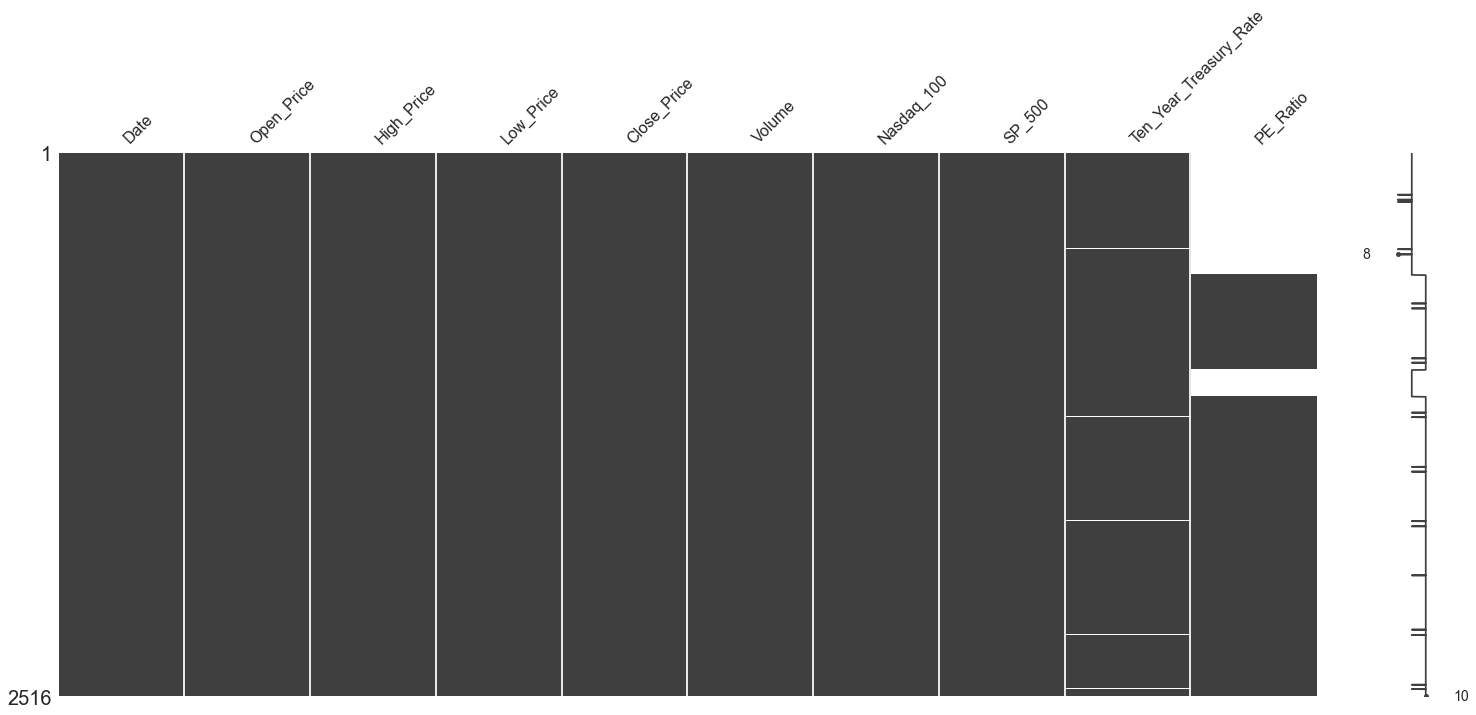

In [6]:
msno.matrix(orig_dt)

### Response: Open Price of the next day --> Add new column

In [7]:
orig_dt[['Next_Day_Open_Price']] = orig_dt[['Open_Price']].shift(-1)
# Delete the last day since we do not have a response
orig_dt.drop(orig_dt.tail(1).index,inplace=True)

<AxesSubplot:>

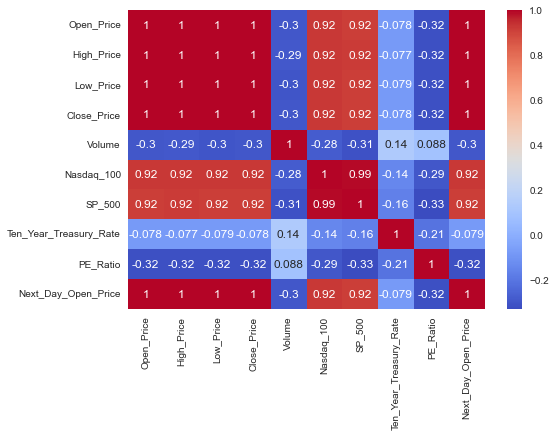

In [11]:
sns.heatmap(orig_dt.corr(), annot=True, cmap='coolwarm')

In [12]:
orig_dt.isna().sum()

Date                        0
Open_Price                  0
High_Price                  0
Low_Price                   0
Close_Price                 0
Volume                      0
Nasdaq_100                  1
SP_500                      0
Ten_Year_Treasury_Rate     19
PE_Ratio                  690
Next_Day_Open_Price         0
dtype: int64

### Convert Date as day before today

In [13]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta



orig_dt['Date'] = pd.to_datetime (orig_dt['Date'])
# Calculate number of days before today's date
today = datetime.now()
orig_dt['DaysBeforeToday'] = (today - orig_dt['Date']).dt.days


### Check distribution of features

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

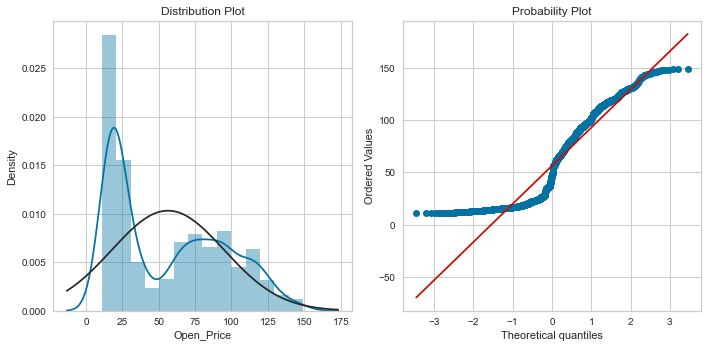

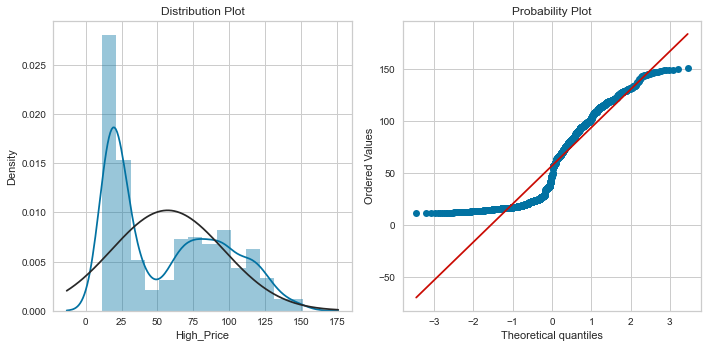

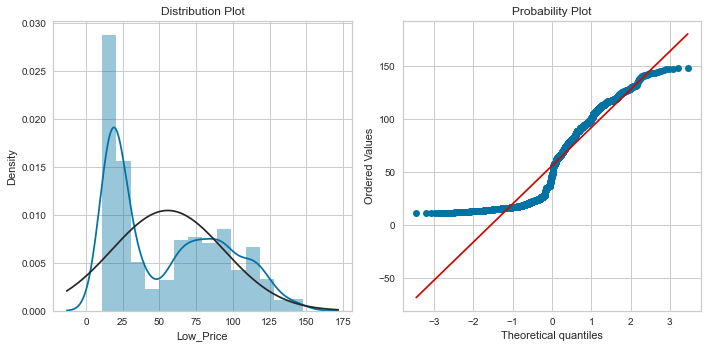

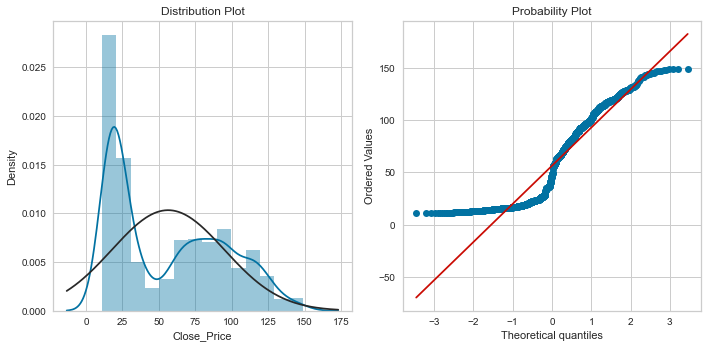

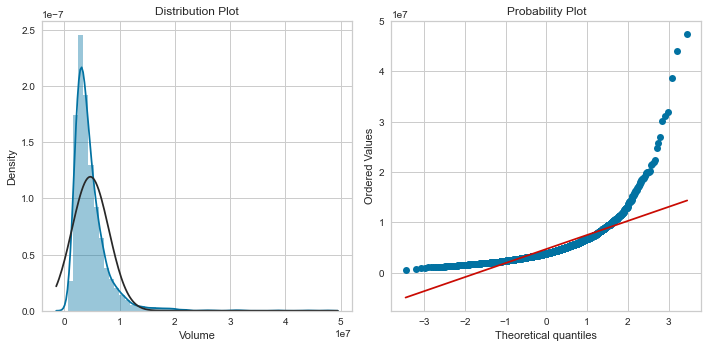

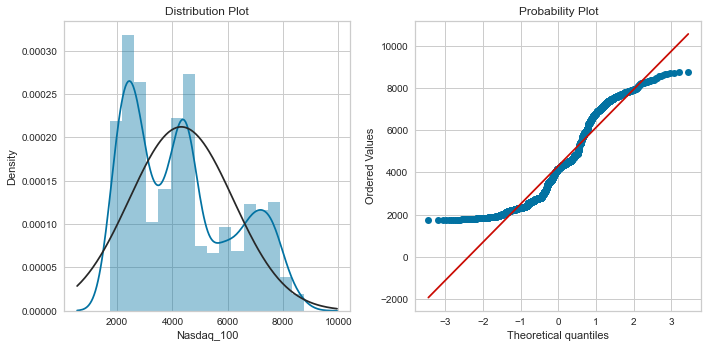

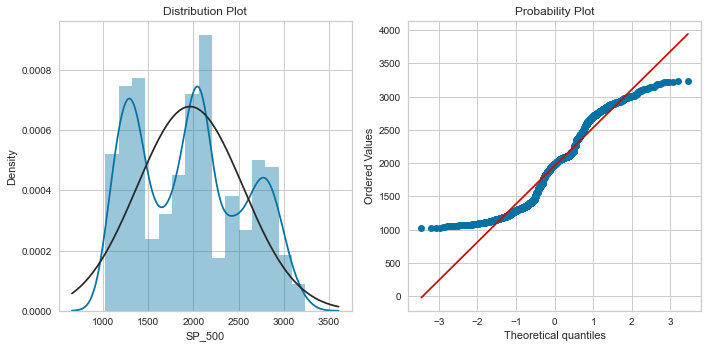

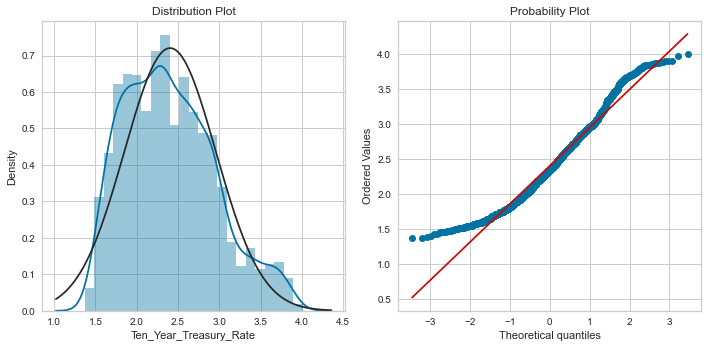

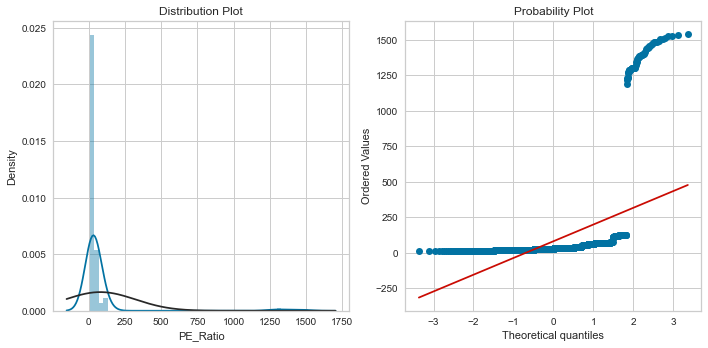

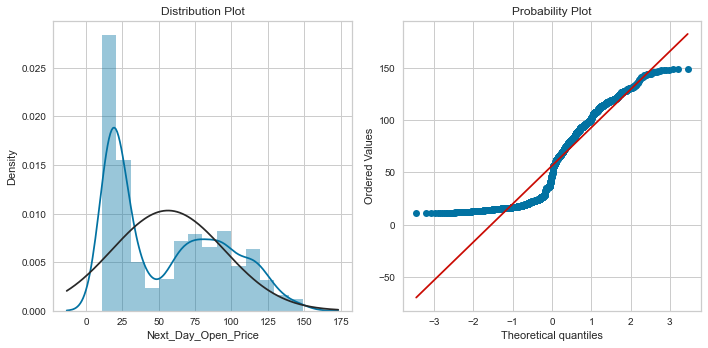

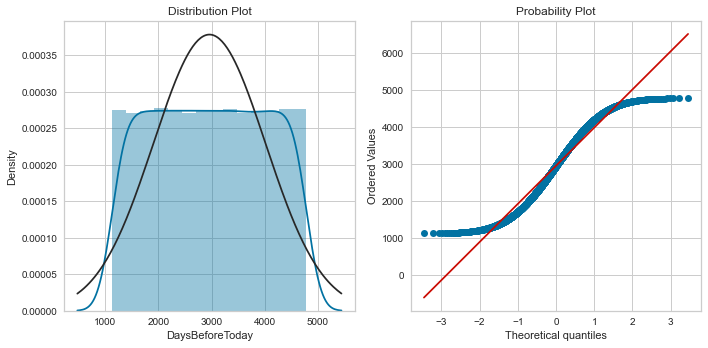

Text(0.5, 0, 'Date')

Text(0, 0.5, 'DaysBeforeToday')

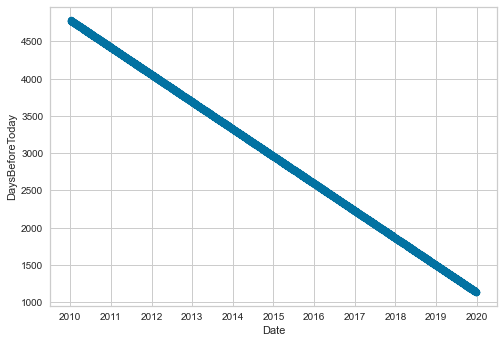

Text(0.5, 0, 'Open_Price')

Text(0, 0.5, 'DaysBeforeToday')

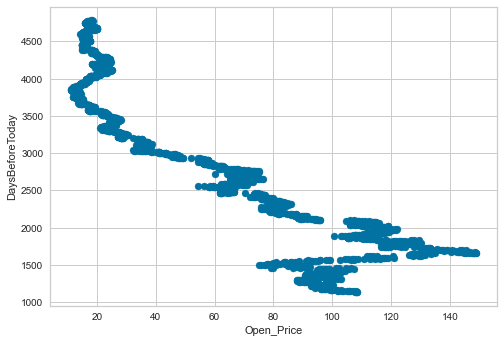

Text(0.5, 0, 'High_Price')

Text(0, 0.5, 'DaysBeforeToday')

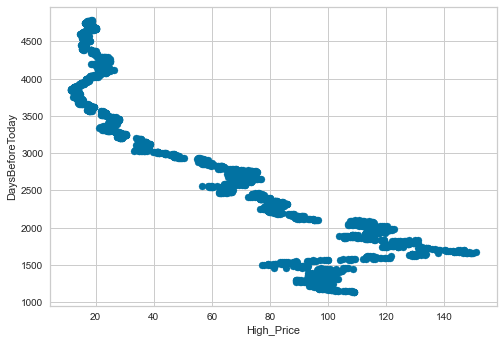

Text(0.5, 0, 'Low_Price')

Text(0, 0.5, 'DaysBeforeToday')

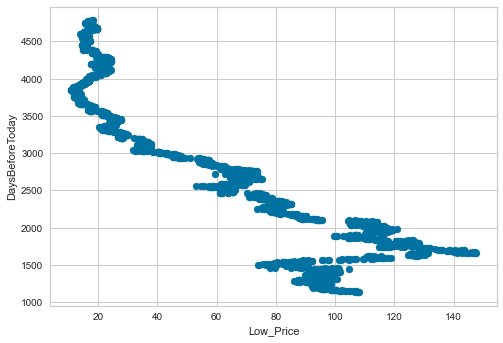

Text(0.5, 0, 'Close_Price')

Text(0, 0.5, 'DaysBeforeToday')

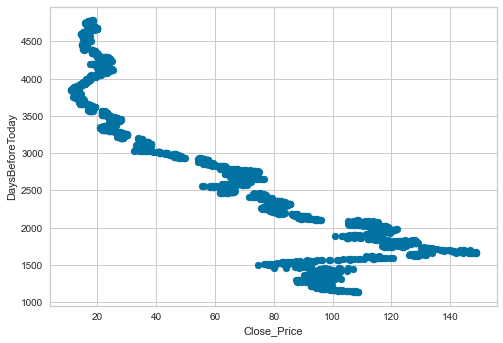

Text(0.5, 0, 'Volume')

Text(0, 0.5, 'DaysBeforeToday')

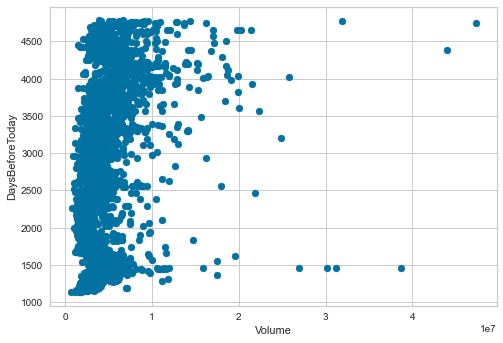

Text(0.5, 0, 'Nasdaq_100')

Text(0, 0.5, 'DaysBeforeToday')

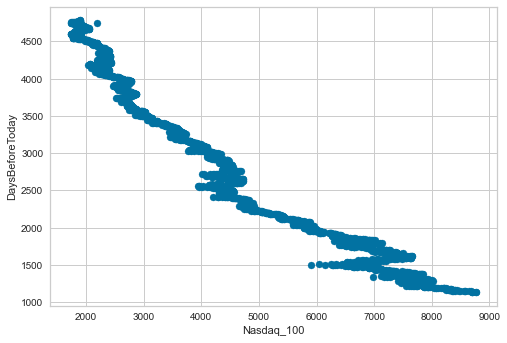

Text(0.5, 0, 'SP_500')

Text(0, 0.5, 'DaysBeforeToday')

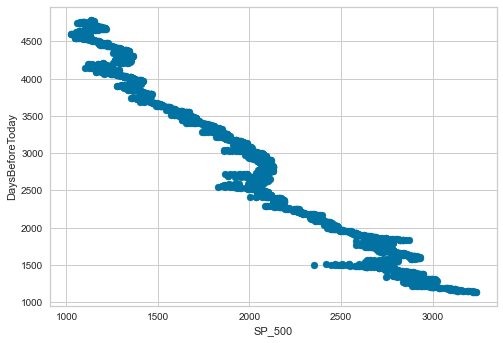

Text(0.5, 0, 'Ten_Year_Treasury_Rate')

Text(0, 0.5, 'DaysBeforeToday')

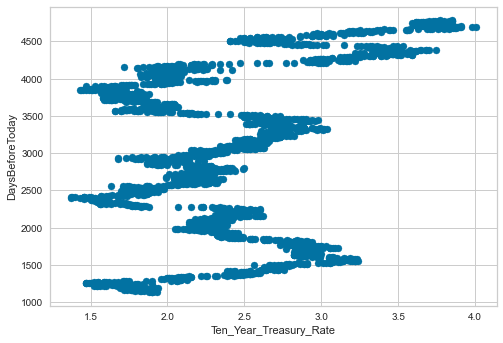

Text(0.5, 0, 'PE_Ratio')

Text(0, 0.5, 'DaysBeforeToday')

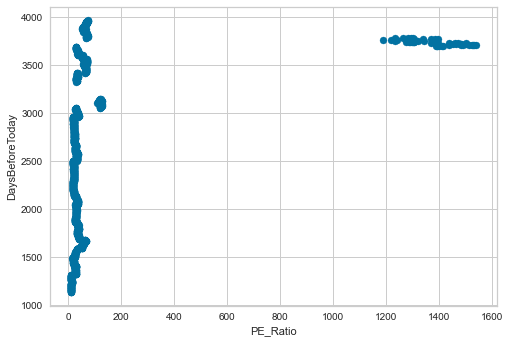

Text(0.5, 0, 'Next_Day_Open_Price')

Text(0, 0.5, 'DaysBeforeToday')

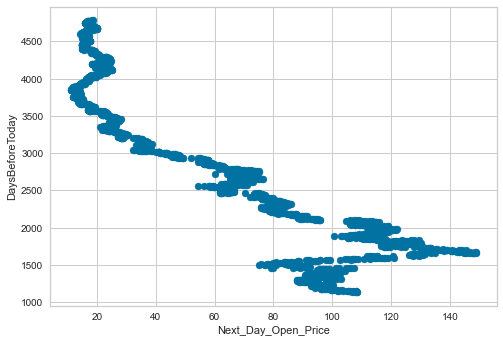

Text(0.5, 0, 'DaysBeforeToday')

Text(0, 0.5, 'DaysBeforeToday')

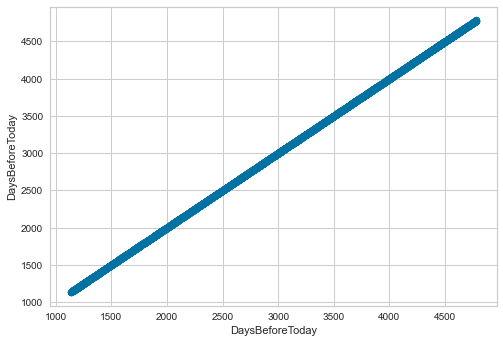

In [14]:
from scipy.stats import norm

def normality_plot(X):
    """
    1. Draw distribution plot with normal distribution fitted curve
    2. Draw Quantile-Quantile plot 
    """
    fig, axes = plt.subplots(1,2, figsize=(10, 5))

    sns.distplot(X, fit=norm, ax=axes[0])
    axes[0].set_title('Distribution Plot')

    axes[1] = stats.probplot((X), plot=plt)
    plt.tight_layout()
# Fit normal distributions to the columns and plot them
for col in orig_dt.columns:
    if col == 'Date':
        continue
    normality_plot(orig_dt[col].dropna())

plt.legend()
plt.show()
for col in orig_dt.columns:


    plt.scatter(orig_dt[col], orig_dt['DaysBeforeToday'])
    # add labels to the x and y axes
    plt.xlabel(col)
    plt.ylabel('DaysBeforeToday')
    plt.show()


# Use polynomial regression fill the missing nasdaq_100 value

In [15]:
orig_dt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
temp = orig_dt[['SP_500', 'Nasdaq_100']]
temp = temp.dropna()
# Generate polynomial features
X = temp[['SP_500']].values
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Fit a linear regression model to the polynomial features
y = temp['Nasdaq_100'].values
reg = LinearRegression().fit(X_poly, y)

# Predict the missing values in Nasdaq_100
col2_pred = reg.predict(poly.transform(orig_dt[orig_dt['Nasdaq_100'].isna()]['SP_500'].values.reshape(-1, 1)))
orig_dt.loc[orig_dt['Nasdaq_100'].isna(), 'Nasdaq_100'] = col2_pred



,Date,Open_Price,High_Price,Low_Price,Close_Price,Volume,Nasdaq_100,SP_500,Ten_Year_Treasury_Rate,PE_Ratio,Next_Day_Open_Price,DaysBeforeToday
3,2010-01-04,17.95,18.235001,17.89,18.15,3853582.0,1886.7000,1132.985478,3.85,NaN,18.30,4782
4,2010-01-05,18.30,18.870000,18.23,18.66,6632992.0,1888.4300,1136.523386,3.77,NaN,18.65,4781
5,2010-01-06,18.65,18.650000,18.06,18.18,5047203.0,1878.4200,1137.137830,3.85,NaN,17.91,4780
6,2010-01-07,17.91,18.070000,17.78,18.04,5437890.0,1876.7200,1141.694928,3.85,NaN,18.12,4779
7,2010-01-08,18.12,18.450000,18.03,18.40,4055760.0,1892.5900,1144.983058,3.83,NaN,18.47,4778
...,...,...,...,...,...,...,...,...,...,...,...,...
3643,2019-12-23,108.27,108.920000,107.67,107.79,1622621.0,8696.0072,3224.009886,1.93,11.7291,107.78,1142
3644,2019-12-24,107.78,108.870000,107.73,108.55,606064.0,8699.5055,3223.375700,1.90,11.8118,108.56,1141
3646,2019-12-26,108.56,108.888000,108.11,108.51,1676723.0,8778.3138,3239.907138,1.90,11.8074,108.60,1139
3647,2019-12-27,108.60,108.890000,107.80,108.43,1163444.0,8770.9791,3240.020358,1.88,11.7987,108.11,1138


In [16]:
orig_dt.isna().sum()
orig_dt.drop(columns='Date', inplace=True)

Date                        0
Open_Price                  0
High_Price                  0
Low_Price                   0
Close_Price                 0
Volume                      0
Nasdaq_100                  0
SP_500                      0
Ten_Year_Treasury_Rate     19
PE_Ratio                  690
Next_Day_Open_Price         0
DaysBeforeToday             0
dtype: int64

# Using linear regression filled out the 10_year_treasury

In [17]:
miss_some = orig_dt.assign( Ten_Year_Treasury_Rate = orig_dt['Ten_Year_Treasury_Rate'].interpolate(method='linear'))

In [18]:
miss_some.dtypes

Open_Price                float64
High_Price                float64
Low_Price                 float64
Close_Price               float64
Volume                    float64
Nasdaq_100                float64
SP_500                    float64
Ten_Year_Treasury_Rate    float64
PE_Ratio                  float64
Next_Day_Open_Price       float64
DaysBeforeToday             int64
dtype: object

# Using deep learning to fill the missing PE values

In [19]:
miss_some.isna().sum()

Open_Price                  0
High_Price                  0
Low_Price                   0
Close_Price                 0
Volume                      0
Nasdaq_100                  0
SP_500                      0
Ten_Year_Treasury_Rate      0
PE_Ratio                  690
Next_Day_Open_Price         0
DaysBeforeToday             0
dtype: int64

In [20]:
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta

train = miss_some[miss_some['PE_Ratio'].notna()]
test = miss_some[miss_some['PE_Ratio'].isna()]
X_train = train.drop(columns='PE_Ratio')
y_train = train[["PE_Ratio"]]
X_test = test.drop(columns='PE_Ratio')
sc = StandardScaler()
X_train = sc.fit_transform(X_train.values)
X_test = sc.transform(X_test.values)


In [21]:
train

,Open_Price,High_Price,Low_Price,Close_Price,Volume,Nasdaq_100,SP_500,Ten_Year_Treasury_Rate,PE_Ratio,Next_Day_Open_Price,DaysBeforeToday
822,16.48,16.790,16.27,16.71,4286702.0,2784.4200,1419.043790,2.22,75.9545,16.63,3963
823,16.63,16.870,16.59,16.65,5752780.0,2782.7800,1413.380591,2.30,75.6818,16.51,3962
824,16.51,16.650,16.23,16.26,3841361.0,2745.0000,1398.958581,2.25,73.9091,16.21,3961
825,16.21,16.430,16.15,16.27,3734548.0,2762.5000,1398.084146,2.19,73.9545,16.08,3960
829,16.08,16.150,15.90,15.90,4750726.0,2739.9800,1382.202137,2.06,72.2727,15.81,3956
...,...,...,...,...,...,...,...,...,...,...,...
3643,108.27,108.920,107.67,107.79,1622621.0,8696.0072,3224.009886,1.93,11.7291,107.78,1142
3644,107.78,108.870,107.73,108.55,606064.0,8699.5055,3223.375700,1.90,11.8118,108.56,1141
3646,108.56,108.888,108.11,108.51,1676723.0,8778.3138,3239.907138,1.90,11.8074,108.60,1139
3647,108.60,108.890,107.80,108.43,1163444.0,8770.9791,3240.020358,1.88,11.7987,108.11,1138


In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
# define base model
def baseline_model_simple():
    # create model
    model = Sequential()
    model.add(Dense(units=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=26, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(units=13, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
# Fitting to the training set
estimator = KerasRegressor(build_fn=baseline_model_simple, epochs=250, batch_size=500, verbose=2)
estimator.fit(X_train, y_train)
# Predicting the results
prediction = estimator.predict(X_test)

Epoch 1/250


2023-02-07 16:30:13.793850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 - 1s - loss: 65072.8398 - 505ms/epoch - 126ms/step
Epoch 2/250
4/4 - 0s - loss: 65071.9648 - 8ms/epoch - 2ms/step
Epoch 3/250
4/4 - 0s - loss: 65071.0078 - 12ms/epoch - 3ms/step
Epoch 4/250
4/4 - 0s - loss: 65069.8750 - 9ms/epoch - 2ms/step
Epoch 5/250
4/4 - 0s - loss: 65068.5664 - 9ms/epoch - 2ms/step
Epoch 6/250
4/4 - 0s - loss: 65067.0117 - 9ms/epoch - 2ms/step
Epoch 7/250
4/4 - 0s - loss: 65064.9844 - 23ms/epoch - 6ms/step
Epoch 8/250
4/4 - 0s - loss: 65062.3828 - 17ms/epoch - 4ms/step
Epoch 9/250
4/4 - 0s - loss: 65058.8477 - 10ms/epoch - 2ms/step
Epoch 10/250
4/4 - 0s - loss: 65054.1680 - 11ms/epoch - 3ms/step
Epoch 11/250
4/4 - 0s - loss: 65047.8125 - 8ms/epoch - 2ms/step
Epoch 12/250
4/4 - 0s - loss: 65039.4258 - 10ms/epoch - 3ms/step
Epoch 13/250
4/4 - 0s - loss: 65028.1836 - 10ms/epoch - 3ms/step
Epoch 14/250
4/4 - 0s - loss: 65013.1523 - 16ms/epoch - 4ms/step
Epoch 15/250
4/4 - 0s - loss: 64994.5898 - 8ms/epoch - 2ms/step
Epoch 16/250
4/4 - 0s - loss: 64968.8672 - 11ms/e

2/2 - 0s - 131ms/epoch - 66ms/step


In [23]:
prediction0 = prediction
prediction0 = prediction0.tolist()
prediction0

[27.5930118560791,
 29.05060577392578,
 25.352821350097656,
 25.01252555847168,
 27.914714813232422,
 23.934833526611328,
 10.825851440429688,
 19.971067428588867,
 27.35915184020996,
 33.3537712097168,
 32.83546829223633,
 37.87626647949219,
 37.66714096069336,
 49.100948333740234,
 45.72455596923828,
 51.9583740234375,
 38.09707260131836,
 33.654483795166016,
 53.4816780090332,
 47.337337493896484,
 42.65653610229492,
 38.67182159423828,
 55.621376037597656,
 50.927284240722656,
 36.33982467651367,
 5.699468612670898,
 30.02284812927246,
 36.76398849487305,
 38.386009216308594,
 47.66756057739258,
 32.81926345825195,
 34.3961067199707,
 28.36579704284668,
 29.078649520874023,
 47.54159164428711,
 50.4632568359375,
 52.160030364990234,
 58.16277313232422,
 56.041629791259766,
 53.86196517944336,
 59.68486404418945,
 59.07999801635742,
 42.59815979003906,
 36.00019073486328,
 24.388851165771484,
 31.471805572509766,
 32.978355407714844,
 39.75920867919922,
 41.984676361083984,
 39.2138

In [24]:
for index, row in miss_some.iterrows():
    if not np.isnan(row['PE_Ratio']):
        continue
    miss_some.at[index,'PE_Ratio'] = prediction0.pop(0)
        

### Visualize the data

In [25]:
miss_some.isna().sum()

Open_Price                0
High_Price                0
Low_Price                 0
Close_Price               0
Volume                    0
Nasdaq_100                0
SP_500                    0
Ten_Year_Treasury_Rate    0
PE_Ratio                  0
Next_Day_Open_Price       0
DaysBeforeToday           0
dtype: int64

<AxesSubplot:>

No handles with labels found to put in legend.


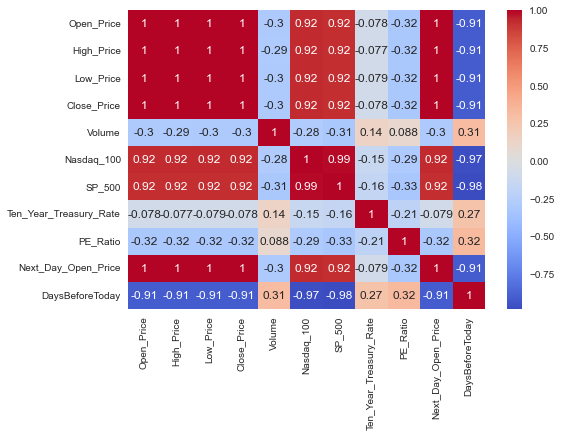

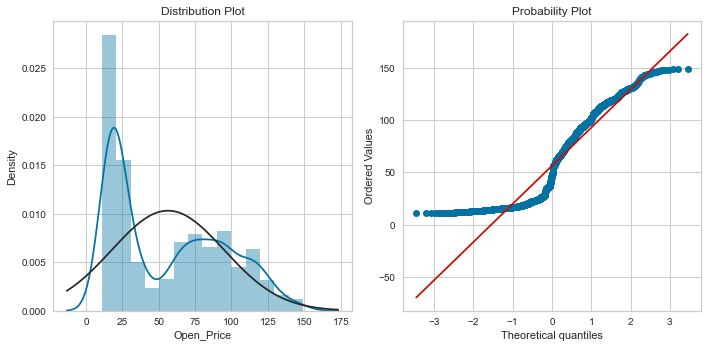

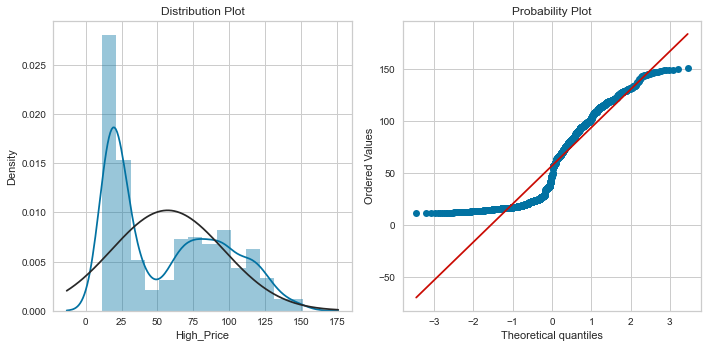

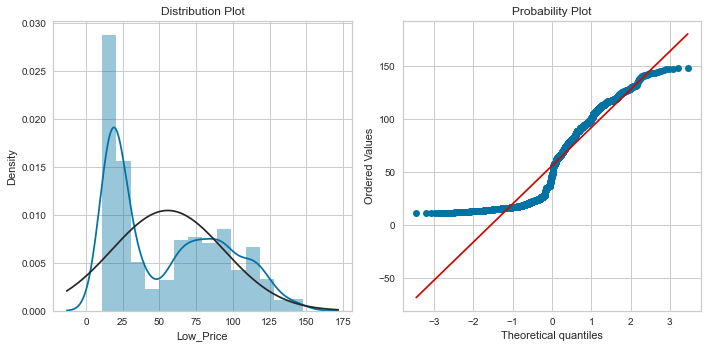

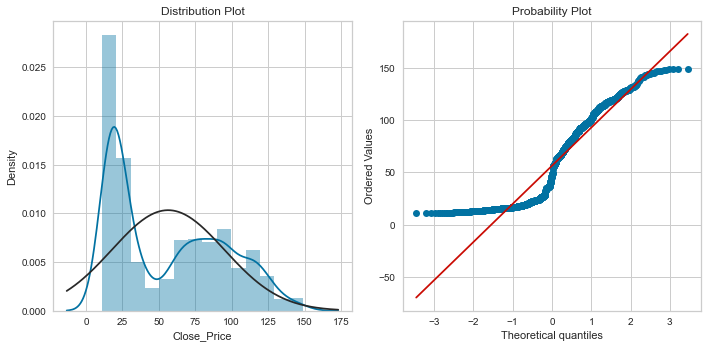

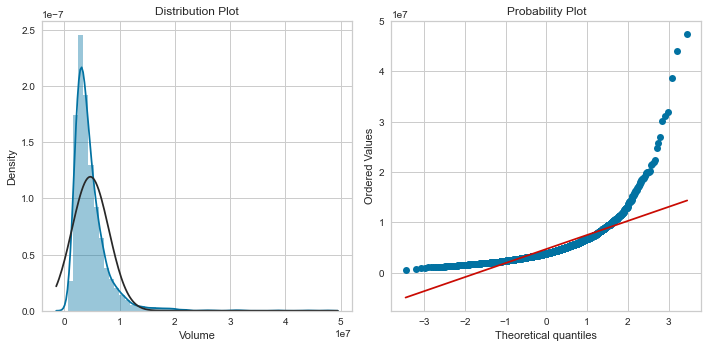

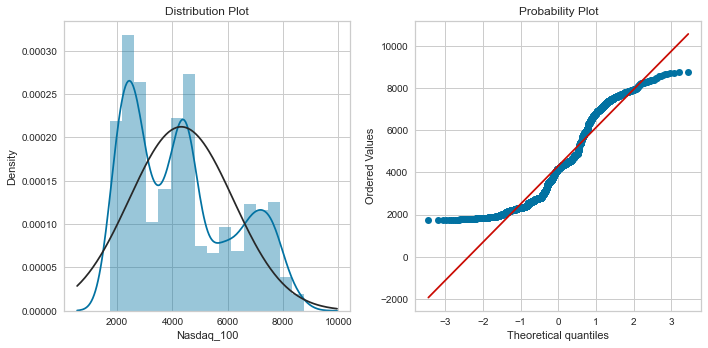

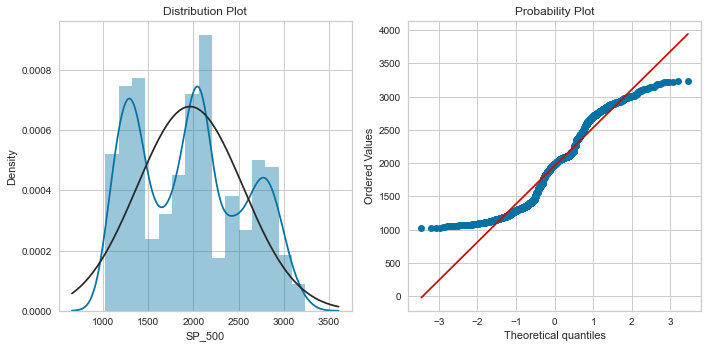

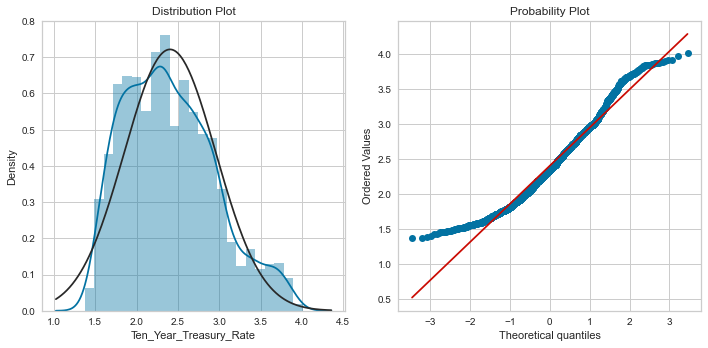

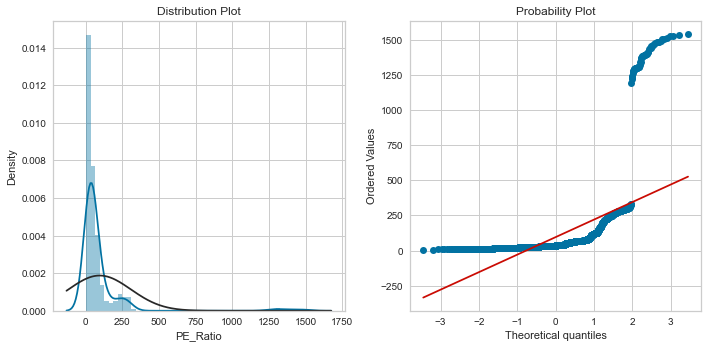

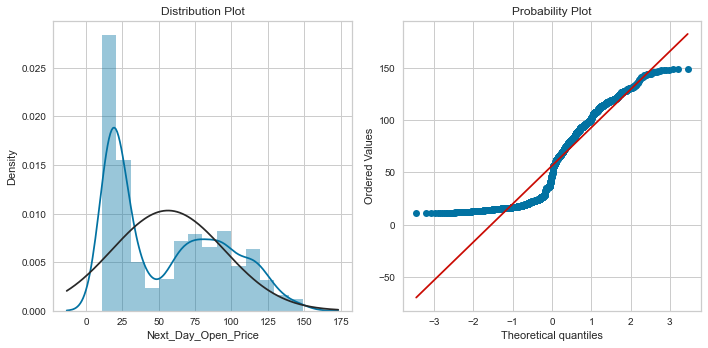

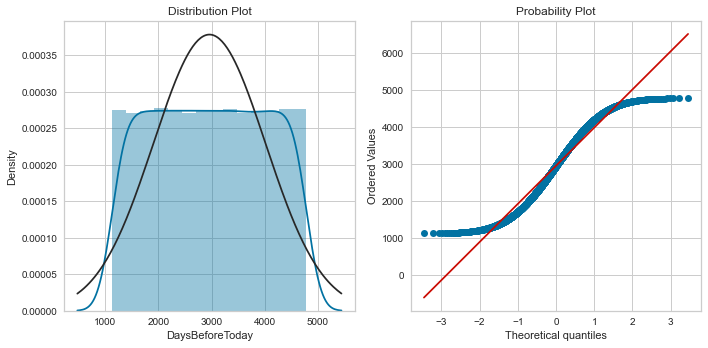

Text(0.5, 0, 'Open_Price')

Text(0, 0.5, 'DaysBeforeToday ')

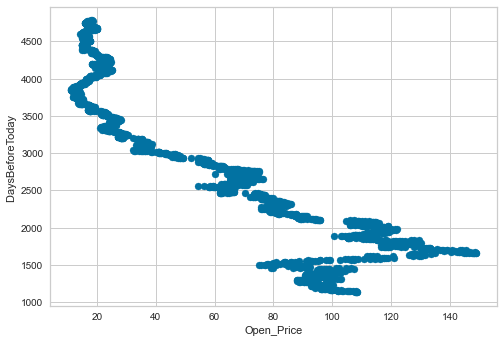

Text(0.5, 0, 'High_Price')

Text(0, 0.5, 'DaysBeforeToday ')

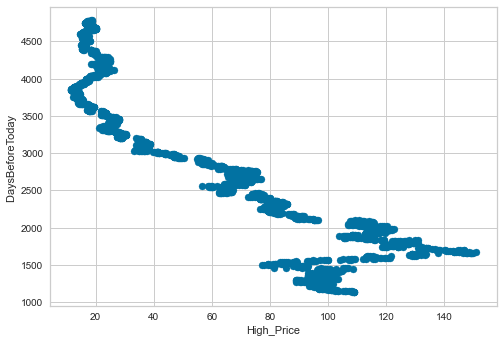

Text(0.5, 0, 'Low_Price')

Text(0, 0.5, 'DaysBeforeToday ')

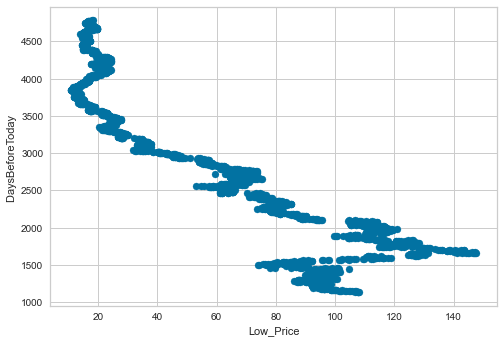

Text(0.5, 0, 'Close_Price')

Text(0, 0.5, 'DaysBeforeToday ')

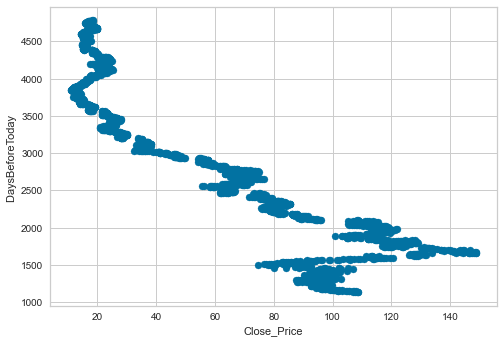

Text(0.5, 0, 'Volume')

Text(0, 0.5, 'DaysBeforeToday ')

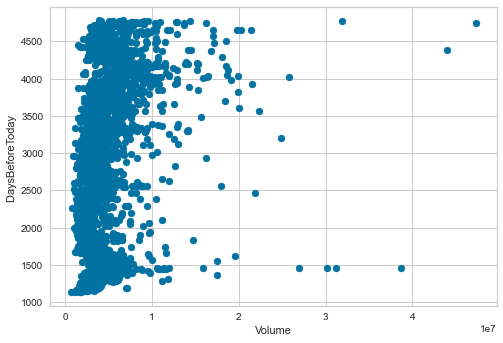

Text(0.5, 0, 'Nasdaq_100')

Text(0, 0.5, 'DaysBeforeToday ')

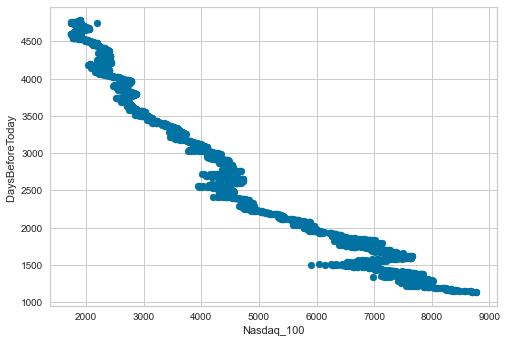

Text(0.5, 0, 'SP_500')

Text(0, 0.5, 'DaysBeforeToday ')

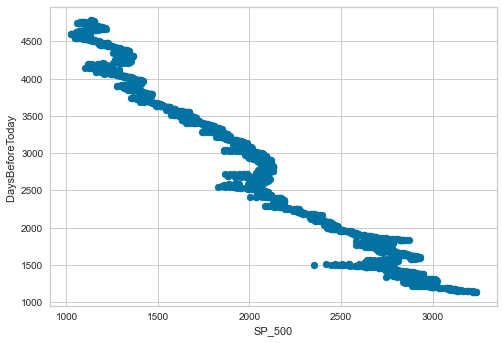

Text(0.5, 0, 'Ten_Year_Treasury_Rate')

Text(0, 0.5, 'DaysBeforeToday ')

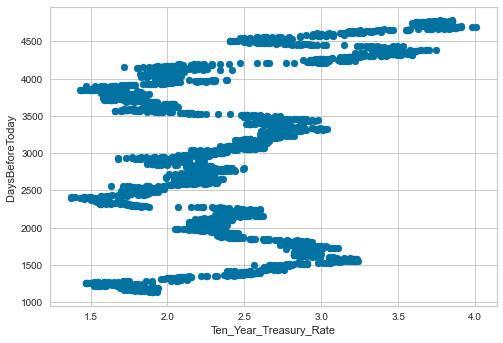

Text(0.5, 0, 'PE_Ratio')

Text(0, 0.5, 'DaysBeforeToday ')

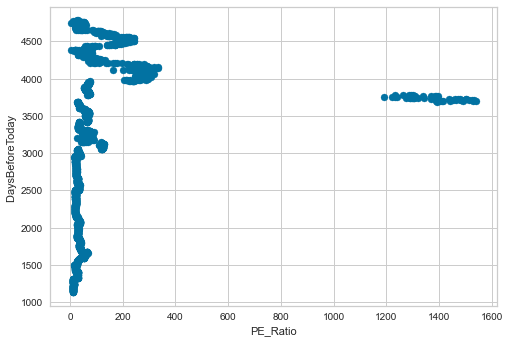

Text(0.5, 0, 'Next_Day_Open_Price')

Text(0, 0.5, 'DaysBeforeToday ')

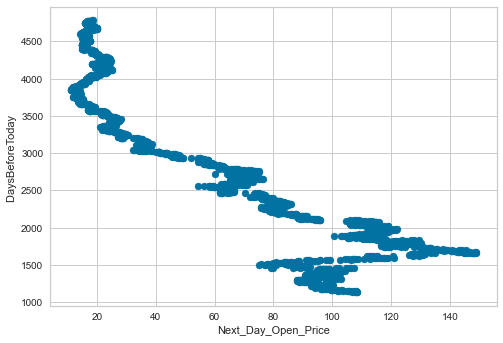

Text(0.5, 0, 'DaysBeforeToday')

Text(0, 0.5, 'DaysBeforeToday ')

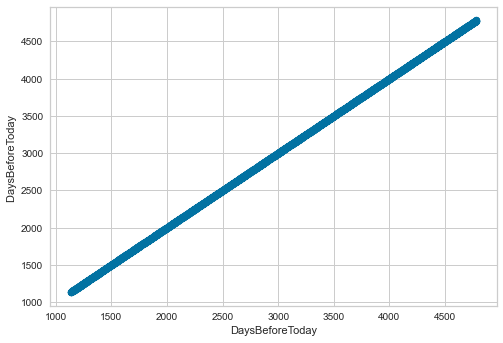

In [26]:
sns.heatmap(orig_dt.corr(), annot=True, cmap='coolwarm')
def normality_plot(X):
    """
    1. Draw distribution plot with normal distribution fitted curve
    2. Draw Quantile-Quantile plot 
    """
    fig, axes = plt.subplots(1,2, figsize=(10, 5))

    sns.distplot(X, fit=norm, ax=axes[0])
    axes[0].set_title('Distribution Plot')

    axes[1] = stats.probplot((X), plot=plt)
    plt.tight_layout()
# Fit normal distributions to the columns and plot them
for col in miss_some.columns:
    normality_plot(miss_some[col])
    # create the scatter plot


plt.legend()
plt.show()


for col in miss_some.columns:
    plt.scatter(miss_some[col], miss_some['DaysBeforeToday'])
    # add labels to the x and y axes
    plt.xlabel(col)
    plt.ylabel('DaysBeforeToday ')
    plt.show()

In [27]:
data_filled = miss_some

### Save back

In [28]:
data_filled.to_csv("../dataset/ea_data.csv", index=False)

### Split Training and Testing Data

In [29]:
training_data = data_filled.iloc[0:2012]
testing_data = data_filled.drop(training_data.index)
print(data_filled.shape[0])
print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

training_data.to_csv("../dataset/ea_training.csv", index=False)
testing_data.to_csv("../dataset/ea_testing.csv", index=False)

2515
No. of training examples: 2012
No. of testing examples: 503
